# Bayesian Online Change Point Detection (BOCPD)
## In Jax

Based on [this tutorial](http://gregorygundersen.com/blog/2019/08/13/bocd/)

In [244]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from itertools import product

In [2]:
%config InlineBackend.figure_format = "retina"

In [211]:
p_stay = 0.97
p_move = 1 - p_stay

transition_matrix = jnp.array([
    [p_stay, p_move, 0.0, 0.0],
    [0.0, p_stay, p_move, 0.0],
    [0.0, 0.0, p_stay, p_move],
    [p_move, 0.0, 0.0, p_stay],
])

n_states, _ = transition_matrix.shape

In [272]:
means = jnp.array([0, -3, 1, 3])
tau = 1

In [273]:
T = 200

def step_hmm(key, s_prev):
    p_transition = transition_matrix[s_prev, :]
    s_next = jax.random.choice(key, n_states, p=p_transition)
    return s_next

def step_process(s_prev, key):
    key_obs, key_step = jax.random.split(key)
    
    s_next = step_hmm(key_step, s_prev)
    mean = means[s_next]
    obs_next = jax.random.normal(key_obs) / tau + mean
    
    output = {
        "state": s_next,
        "obs": obs_next
    }
    return s_next, output

In [274]:
key = jax.random.PRNGKey(271)
key_init, key_steps = jax.random.split(key)
keys = jax.random.split(key_steps, T)

s_init = jax.random.choice(key_init, n_states)
_, outputs = jax.lax.scan(step_process, s_init, keys)

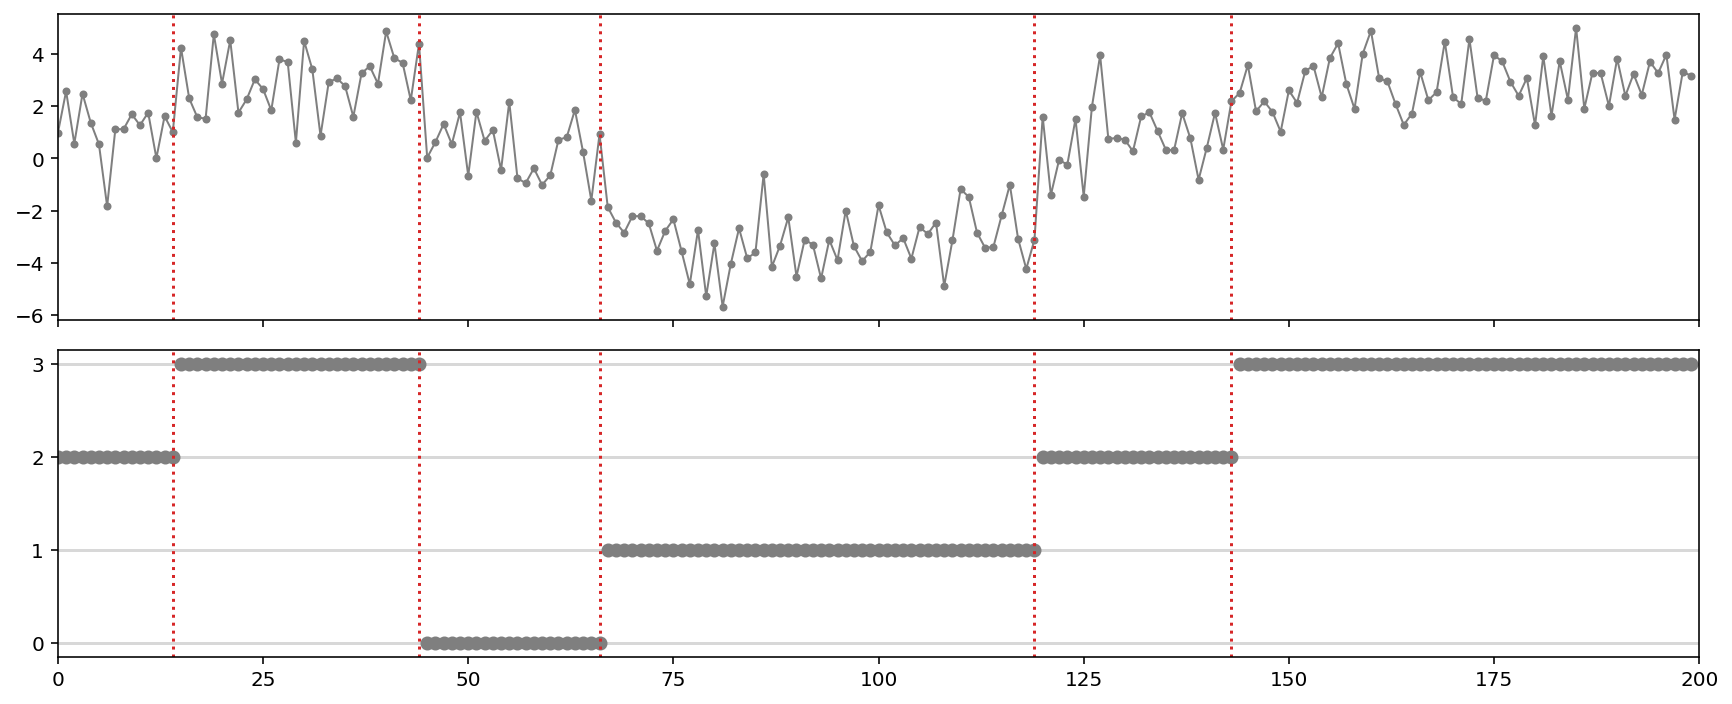

In [279]:
timesteps = jnp.arange(T)
changepoints, *_ = jnp.where(jnp.diff(outputs["state"]) != 0)


fig, ax = plt.subplots(2, 1, figsize=(12, 5), sharex="all")

ax[0].plot(timesteps, outputs["obs"], marker="o", markersize=3, linewidth=1, c="tab:gray")
    
ax[1].scatter(timesteps, outputs["state"], c="tab:gray")
ax[1].set_yticks(jnp.arange(n_states))
for y in range(n_states):
    ax[1].axhline(y=y, c="tab:gray", alpha=0.3)
    
    
for changepoint, axi in product(changepoints, ax):
    axi.axvline(x=changepoint, c="tab:red", linestyle="dotted")
    
plt.tight_layout()
plt.xlim(0, T);